In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

from lib.data.datareader_total import DataReaderTotal
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.datareader_fit3d import DataReaderFIT3D
from lib.utils.args import get_opts_args
from lib.model.load_model import load_model
from lib.model.load_dataset import load_dataset
from lib.data.dataset_motion_3d import MotionDataset3DTotal
from lib.model.evaluation import *

In [2]:
dataset_name = 'h36m'
overwrite_list = []
source_list                    = load_data(dataset_name=dataset_name, data_type='source_list', overwrite_list=overwrite_list)
cam_params                     = load_data(dataset_name=dataset_name, data_type='cam_param', overwrite_list=overwrite_list)
world_3ds                      = load_data(dataset_name=dataset_name, data_type='world_3d', overwrite_list=overwrite_list)
cam_3ds                        = load_data(dataset_name=dataset_name, data_type='cam_3d', overwrite_list=overwrite_list)
img_2ds                        = load_data(dataset_name=dataset_name, data_type='img_2d', overwrite_list=overwrite_list)
img_3ds                        = load_data(dataset_name=dataset_name, data_type='img_3d', overwrite_list=overwrite_list)
scale_factors                  = load_data(dataset_name=dataset_name, data_type='scale_factor', overwrite_list=overwrite_list)
img_25ds                       = load_data(dataset_name=dataset_name, data_type='img_25d', overwrite_list=overwrite_list)
cam_3d_canonicals_same_z       = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='same_z', overwrite_list=overwrite_list)
cam_3d_canonicals_same_dist    = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='same_dist', overwrite_list=overwrite_list)
cam_3d_canonicals_fixed_dist_5 = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='fixed_dist_5', overwrite_list=overwrite_list)
img_2d_canonicals_same_z       = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='same_z', overwrite_list=overwrite_list)
img_2d_canonicals_same_dist    = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='same_dist', overwrite_list=overwrite_list)
img_2d_canonicals_fixed_dist_5 = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='fixed_dist_5', overwrite_list=overwrite_list)

==> Loading H36M source_list... overwrite: False
==> Loading H36M cam_param... overwrite: False
==> Loading H36M world_3d... overwrite: False
==> Loading H36M cam_3d... overwrite: False
==> Loading H36M img_2d... overwrite: False
==> Loading H36M img_3d... overwrite: False
==> Loading H36M scale_factor... overwrite: False
==> Loading H36M img_25d... overwrite: False
==> Loading H36M cam_3d_canonical_same_z... overwrite: False
==> Loading H36M cam_3d_canonical_same_dist... overwrite: False
==> Loading H36M cam_3d_canonical_fixed_dist_5... overwrite: False
==> Loading H36M img_2d_canonical_same_z... overwrite: False
==> Loading H36M img_2d_canonical_same_dist... overwrite: False
==> Loading H36M img_2d_canonical_fixed_dist_5... overwrite: False


In [3]:
# check constraints
for source in source_list:
    subject, cam_id, action = split_source_name(source, dataset_name)
    world_3d = world_3ds[subject][action]
    cam_3d = cam_3ds[subject][action][cam_id]
    img_2d = img_2ds[subject][action][cam_id]
    img_3d = img_3ds[subject][action][cam_id]
    cam_3d_canonical_same_z = cam_3d_canonicals_same_z[subject][action][cam_id]
    cam_3d_canonical_same_dist = cam_3d_canonicals_same_dist[subject][action][cam_id]
    cam_3d_canonical_fixed_dist_5 = cam_3d_canonicals_fixed_dist_5[subject][action][cam_id]
    assert world_3d.shape[1:] == (17, 3), f'{source} {world_3ds[subject][action].shape}'
    assert world_3d.mean() < 5, f'{source} {world_3d.mean()}'
    assert cam_3d.shape[1:] == (17, 3), f'{source} {cam_3d.shape}'
    assert cam_3d.mean() < 5, f'{source} {cam_3d.mean()}'
    assert img_2d.mean() > 1, f'{source} {img_2d.mean()}'
    assert np.allclose(img_2d, img_3d[...,:2]), f'image 2d and 3d are not equal'
    assert np.allclose(cam_3d[...,2], cam_3d_canonical_same_z[...,2]), 'Z values should be same'
    assert np.allclose(np.linalg.norm(cam_3d[:, 0], axis=1), cam_3d_canonical_same_dist[:, 0, 2]), 'Distances should be same'
    assert np.allclose(np.array([5.0]*len(cam_3d)), cam_3d_canonical_fixed_dist_5[:, 0, 2]), 'Distances should be same'

### Check world_3d, cam_3d, img_2d

S1 54138969 Waiting 1


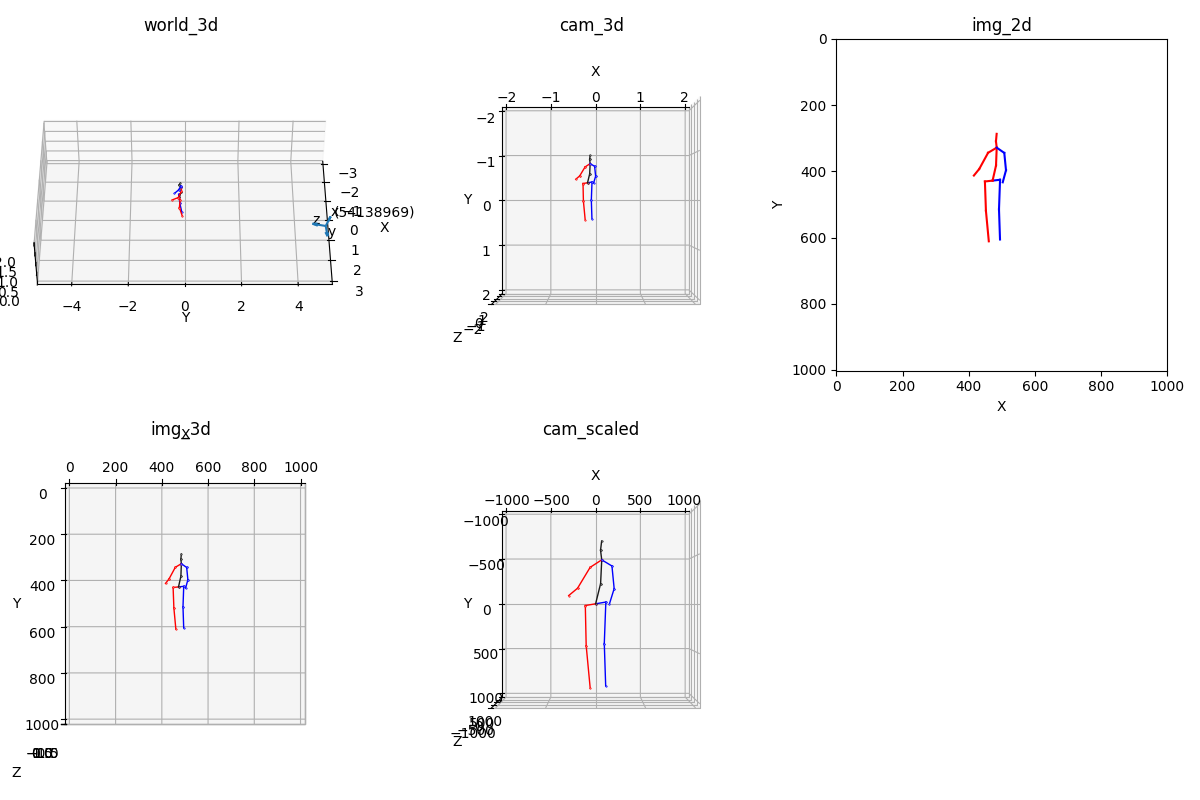

In [5]:
%matplotlib widget
scale_factors = None

source = source_list[0]
subject, cam_id, seq = split_source_name(source, dataset_name)
print(subject, cam_id, seq)

cam_param = cam_params[subject][seq][cam_id]
R, t, C, W, H, intrinsic = cam_param['R'], cam_param['t'], cam_param['C'], cam_param['W'], cam_param['H'], cam_param['intrinsic']
plot_configs = load_plot_configs(dataset_name)
    
fig = plt.figure(0, layout='constrained', figsize=(12, 8))
fig.clear()
ax_world_3d = axes_3d(fig, loc=231, 
                      xlim=plot_configs['ax_world_3d_xlim'], 
                      ylim=plot_configs['ax_world_3d_ylim'], 
                      zlim=plot_configs['ax_world_3d_zlim'],
                      view=plot_configs['ax_world_3d_view'])
ax_cam_3d = axes_3d(fig, loc=232, 
                    view=plot_configs['ax_cam_3d_view'])
ax_img_2d = axes_2d(fig, loc=233, W=W, H=H)
ax_img_3d = axes_3d(fig, loc=234, 
                    xlim=(0, W), 
                    ylim=(0, H), 
                    zlim=(-1, 1),
                    view=plot_configs['ax_img_3d_view'])
ax_cam_scaled = axes_3d(fig, loc=235, 
                        xlim=plot_configs['ax_cam_scaled_xlim'], 
                        ylim=plot_configs['ax_cam_scaled_ylim'], 
                        zlim=plot_configs['ax_cam_scaled_zlim'],
                        view=plot_configs['ax_cam_scaled_view'])

ax_world_3d.set_title('world_3d')
ax_cam_3d.set_title('cam_3d')
ax_img_2d.set_title('img_2d')
ax_img_3d.set_title('img_3d')
ax_cam_scaled.set_title('cam_scaled')

plt.sca(ax_world_3d)
camera = Camera(origin=C, 
                calib_mat=intrinsic, 
                cam_default_R=R, 
                IMAGE_HEIGHT=H, 
                IMAGE_WIDTH=W,
                cam_name=cam_id)
camera.cam_frame.draw3d()
    
frame_num = 0      
world_3d = world_3ds[subject][seq][frame_num]
cam_3d   = cam_3ds[subject][seq][cam_id][frame_num]
img_2d   = img_2ds[subject][seq][cam_id][frame_num]
img_3d   = img_3ds[subject][seq][cam_id][frame_num]

if scale_factors is not None:
    scale_factor = scale_factors[subject][seq][cam_id][frame_num]
cam_3d_hat = cam_3d - cam_3d[0]
img_3d_hat = img_3d - img_3d[0]
img = load_image_frame(dataset_name, source, frame_num)

draw_3d_pose(ax_world_3d, world_3d)
draw_3d_pose(ax_cam_3d, cam_3d)
draw_2d_pose(ax_img_2d, img_2d, W=W, H=H, img=img)
draw_3d_pose(ax_img_3d, img_3d)
draw_3d_pose(ax_cam_scaled, cam_3d_hat*1000)
if scale_factors is not None:
    draw_3d_pose(ax_cam_scaled, img_3d_hat/scale_factor, color='r')
plt.tight_layout()
plt.show()

### Canonical Compoarison Video

In [8]:
import concurrent.futures
from multiprocessing import Process


plt.tight_layout()
fig = plt.figure(3, figsize=(12, 8))
fig.clear()

axd = fig.subplot_mosaic(
    """
    ABCD
    EFGH
    """,
    per_subplot_kw={('A', 'B', 'C', 'D'): {'projection': '3d'}}
)

plot_configs = load_plot_configs(dataset_name)

In [9]:
subject, cam_id, action = split_source_name(source_list[0], dataset_name)
cam_param = cam_params[subject][action][cam_id]
R, t, C, W, H, intrinsic = cam_param['R'], cam_param['t'], cam_param['C'], cam_param['W'], cam_param['H'], cam_param['intrinsic']

cam_3d = cam_3ds[subject][action][cam_id]
cam_3d_same_z = cam_3d_canonicals_same_z[subject][action][cam_id]
cam_3d_same_dist = cam_3d_canonicals_same_dist[subject][action][cam_id]
cam_3d_fixed_dist_5 = cam_3d_canonicals_fixed_dist_5[subject][action][cam_id]
img_2d = img_2ds[subject][action][cam_id]
img_2d_same_z = img_2d_canonicals_same_z[subject][action][cam_id]
img_2d_same_dist = img_2d_canonicals_same_dist[subject][action][cam_id]
img_2d_fixed_dist_5 = img_2d_canonicals_fixed_dist_5[subject][action][cam_id]


In [10]:
ax_cam_3d = axes_3d(ax=axd['A'], view=plot_configs['ax_cam_3d_view'], zlim=(0, 0.1), show_axis=False)
ax_cam_3d_same_z = axes_3d(ax=axd['B'], view=plot_configs['ax_cam_3d_view'], zlim=(0, 0.1), show_axis=False)
ax_cam_3d_same_dist = axes_3d(ax=axd['C'], view=plot_configs['ax_cam_3d_view'], zlim=(0, 0.1), show_axis=False)
ax_cam_3d_fixed_dist_5 = axes_3d(ax=axd['D'], view=plot_configs['ax_cam_3d_view'], zlim=(0, 0.1), show_axis=False)
ax_img_2d = axes_2d(ax=axd['E'], W=W, H=H, show_axis=False)
ax_img_2d_same_z = axes_2d(ax=axd['F'], W=W, H=H, show_axis=False)
ax_img_2d_same_dist = axes_2d(ax=axd['G'], W=W, H=H, show_axis=False) 
ax_img_2d_fixed_dist_5 = axes_2d(ax=axd['H'], W=W, H=H, show_axis=False)

ax_cam_3d.set_title('cam_3d')
ax_cam_3d_same_z.set_title('cam_3d_same_z')
ax_cam_3d_same_dist.set_title('cam_3d_same_dist')
ax_cam_3d_fixed_dist_5.set_title('cam_3d_fixed_dist_5')
ax_img_2d.set_title('img_2d')
ax_img_2d_same_z.set_title('img_2d_same_z')
ax_img_2d_same_dist.set_title('img_2d_same_dist')
ax_img_2d_fixed_dist_5.set_title('img_2d_fixed_dist_5')

num_frames = cam_param['num_frames']

In [17]:
from io import BytesIO

def plot_frame(frame_num):
    clear_axes([ax_cam_3d, ax_cam_3d_same_z, ax_cam_3d_same_dist, ax_cam_3d_fixed_dist_5, ax_img_2d, ax_img_2d_same_z, ax_img_2d_same_dist, ax_img_2d_fixed_dist_5])
    img = None# load_image_frame(dataset_name, source, frame_num)
    ax_img_2d.axhline(H//2, color='r', linestyle='--', linewidth=0.5)
    ax_img_2d.axvline(W//2, color='r', linestyle='--', linewidth=0.5)
    ax_img_2d_same_z.axhline(H//2, color='r', linestyle='--', linewidth=0.5)
    ax_img_2d_same_z.axvline(W//2, color='r', linestyle='--', linewidth=0.5)
    ax_img_2d_same_dist.axhline(H//2, color='r', linestyle='--', linewidth=0.5)
    ax_img_2d_same_dist.axvline(W//2, color='r', linestyle='--', linewidth=0.5)
    ax_img_2d_fixed_dist_5.axhline(H//2, color='r', linestyle='--', linewidth=0.5)
    ax_img_2d_fixed_dist_5.axvline(W//2, color='r', linestyle='--', linewidth=0.5)

    draw_3d_pose(ax_cam_3d, cam_3d[frame_num])
    draw_3d_pose(ax_cam_3d_same_z, cam_3d_same_z[frame_num], color='r')
    draw_3d_pose(ax_cam_3d_same_dist, cam_3d_same_dist[frame_num], color='k')
    draw_3d_pose(ax_cam_3d_fixed_dist_5, cam_3d_fixed_dist_5[frame_num], color='b')

    draw_2d_pose(ax_img_2d, img_2d[frame_num], img=img, W=W, H=H)
    draw_2d_pose(ax_img_2d_same_z, img_2d_same_z[frame_num], W=W, H=H, color='r')
    draw_2d_pose(ax_img_2d_same_dist, img_2d_same_dist[frame_num], W=W, H=H, color='k')
    draw_2d_pose(ax_img_2d_fixed_dist_5, img_2d_fixed_dist_5[frame_num], W=W, H=H, color='b')
    # fig.canvas.draw()
    # image_from_plot = np.array(fig.canvas.renderer._renderer)
    # image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)  
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=50)
    buf.seek(0)
    image = imageio.v2.imread(buf)
    return image
    
with imageio.get_writer('test.mp4', fps=5, macro_block_size=1) as writer:
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for image in executor.map(plot_frame, range(0, num_frames, 5)):
            writer.append_data(image)
        #    pass
                 
# for frame_num in tqdm(range(0, num_frames, 5)):
#     pass

In [22]:
for source in tqdm(source_list):
    subject, cam_id, action = split_source_name(source, dataset_name)
    file_path = f'/home/hrai/codes/MotionBERT/custom_codes/canonical/compare_canonical_new/{dataset_name}/{subject}/{subject}_{action}_{cam_id}.mp4'
    if os.path.exists(file_path): 
        print(f'{file_path} exists')
        continue
    
    cam_param = cam_params[subject][action][cam_id]
    R, t, C, W, H, intrinsic = cam_param['R'], cam_param['t'], cam_param['C'], cam_param['W'], cam_param['H'], cam_param['intrinsic']

    cam_3d = cam_3ds[subject][action][cam_id]
    cam_3d_same_z = cam_3d_canonicals_same_z[subject][action][cam_id]
    cam_3d_same_dist = cam_3d_canonicals_same_dist[subject][action][cam_id]
    cam_3d_fixed_dist_5 = cam_3d_canonicals_fixed_dist_5[subject][action][cam_id]
    img_2d = img_2ds[subject][action][cam_id]
    img_2d_same_z = img_2d_canonicals_same_z[subject][action][cam_id]
    img_2d_same_dist = img_2d_canonicals_same_dist[subject][action][cam_id]
    img_2d_fixed_dist_5 = img_2d_canonicals_fixed_dist_5[subject][action][cam_id]
    
    ax_cam_3d = axes_3d(ax=axd['A'], view=plot_configs['ax_cam_3d_view'], zlim=(0, 0.1), show_axis=False)
    ax_cam_3d_same_z = axes_3d(ax=axd['B'], view=plot_configs['ax_cam_3d_view'], zlim=(0, 0.1), show_axis=False)
    ax_cam_3d_same_dist = axes_3d(ax=axd['C'], view=plot_configs['ax_cam_3d_view'], zlim=(0, 0.1), show_axis=False)
    ax_cam_3d_fixed_dist_5 = axes_3d(ax=axd['D'], view=plot_configs['ax_cam_3d_view'], zlim=(0, 0.1), show_axis=False)
    ax_img_2d = axes_2d(ax=axd['E'], W=W, H=H, show_axis=False)
    ax_img_2d_same_z = axes_2d(ax=axd['F'], W=W, H=H, show_axis=False)
    ax_img_2d_same_dist = axes_2d(ax=axd['G'], W=W, H=H, show_axis=False) 
    ax_img_2d_fixed_dist_5 = axes_2d(ax=axd['H'], W=W, H=H, show_axis=False)

    ax_cam_3d.set_title('cam_3d')
    ax_cam_3d_same_z.set_title('cam_3d_same_z')
    ax_cam_3d_same_dist.set_title('cam_3d_same_dist')
    ax_cam_3d_fixed_dist_5.set_title('cam_3d_fixed_dist_5')
    ax_img_2d.set_title('img_2d')
    ax_img_2d_same_z.set_title('img_2d_same_z')
    ax_img_2d_same_dist.set_title('img_2d_same_dist')
    ax_img_2d_fixed_dist_5.set_title('img_2d_fixed_dist_5')

    num_frames = cam_param['num_frames']
    
    with imageio.get_writer(file_path, fps=5, macro_block_size=1) as writer:
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for image in executor.map(plot_frame, range(0, num_frames, 5)):
                writer.append_data(image)
    #break

  0%|          | 0/230 [00:00<?, ?it/s]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical_new/3dhp/S1/S1_Seq1_cam0.mp4 exists


 12%|█▏        | 28/230 [08:25<1:00:47, 18.06s/it]


FileNotFoundError: The directory '/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical_new/3dhp/S2' does not exist